## What is LangGraph?

LangGraph is a powerful framework designed to help developers build intelligent AI agents that can think, plan, and act on your behalf. At its core, LangGraph allows you to break down complex tasks into smaller, manageable steps, organize these steps logically, and connect them like a roadmap using something called **graphs**. These graphs visually represent the flow of tasks, making it easy to see how each step is connected and in what order they should be executed.  

Think of LangGraph as a toolkit for creating smart assistants. These assistants don’t just follow instructions—they understand what you want, figure out the best way to achieve it, and carry out the tasks automatically. By using LangGraph, you can design AI systems that are structured, adaptable, and capable of handling everything from simple workflows to complicated problem-solving tasks.

## Importing Required Libraries

In [1]:
from langgraph.graph import StateGraph
from dotenv import load_dotenv
import os

load_dotenv()

True

## Load Large Langauage Model

In [2]:
from langchain_openai import ChatOpenAI


perplexity_llm = ChatOpenAI(
    base_url="https://api.perplexity.ai",
    api_key=os.getenv("PERPLEXITY_API_KEY"),
    model="sonar-pro",           # ← THIS IS THE CORRECT MODEL
    temperature=0.7
)

print("Perplexity Chatbot is ready!")

Perplexity Chatbot is ready!


In [3]:
from langchain_ollama import ChatOllama

model_name = "llama3.2:latest"  #"qwen2.5:3b"
local_llm = ChatOllama(model=model_name, temperature=0.1)
print("Ollama llm is ready!")

Ollama llm is ready!


## Components of LangGraph

### **1. States**  

In [4]:
from typing import TypedDict, Optional

class AuthState(TypedDict):
    username: Optional[str] 
    password: Optional[str]
    is_authenticated: Optional[bool]
    output: Optional[str]

#### **Example Objects and Their States**

##### **Object 1: Successful Login**
Here is an example of the  ```AuthState ``` object  with a successful login:


In [5]:
auth_state_1: AuthState = {
    "username": "PawanKrGunjan",
    "password": "123",
    "is_authenticated": True,
    "output": "Login successful."
}
print(f"auth_state_1: {auth_state_1}")

auth_state_1: {'username': 'PawanKrGunjan', 'password': '123', 'is_authenticated': True, 'output': 'Login successful.'}


##### Object 2: Unsuccessful Login
Here is an example of the  ```AuthState ``` object with an unsuccessful login:


In [6]:
auth_state_2: AuthState = {
    "username":"",
    "password": "wrongpassword",
    "is_authenticated": False,
    "output": "Authentication failed. Please try again."
}
print(f"auth_state_2: {auth_state_2}")

auth_state_2: {'username': '', 'password': 'wrongpassword', 'is_authenticated': False, 'output': 'Authentication failed. Please try again.'}


### **2. Nodes**

Nodes are the **core units of action** in LangGraph. Each node represents a specific task or operation that the AI agent needs to perform. 

In [7]:
def input_node(state):
    print(state)
    if state.get('username', "") =="":
        state['username'] = input("What is your username?")

    password = input("Enter your password: ")

    return {"password":password}

In [8]:
input_node(auth_state_1)

{'username': 'PawanKrGunjan', 'password': '123', 'is_authenticated': True, 'output': 'Login successful.'}


{'password': '123'}

In [9]:
input_node(auth_state_2)

{'username': '', 'password': 'wrongpassword', 'is_authenticated': False, 'output': 'Authentication failed. Please try again.'}


{'password': '123'}

#### Defining the Validate Credentials Node

In [10]:
def validate_credentials_node(state):
    # Extract username and password from the state
    username = state.get("username", "")
    password = state.get("password", "")

    print("Username :", username, "Password :", password)
    # Simulated credential validation
    if username == "Om" and password == "Password123":
        is_authenticated = True
    else:
        is_authenticated = False

    # Return the updated state with authentication result
    return {"is_authenticated": is_authenticated}

#### Incorrect Format

In [11]:
validate_credentials_node(auth_state_1)

Username : PawanKrGunjan Password : 123


{'is_authenticated': False}

In [12]:
auth_state_3: AuthState = {
    "username":"om",
    "password":  "password123",
    "is_authenticated": False,
    "output": "Authentication failed. Please try again."
}
print(f"auth_state_3: {auth_state_3}")

auth_state_3: {'username': 'om', 'password': 'password123', 'is_authenticated': False, 'output': 'Authentication failed. Please try again.'}


In [13]:
validate_credentials_node(auth_state_3)

Username : om Password : password123


{'is_authenticated': False}

#### Defining the Success Node

In [14]:
# Define the success node
def success_node(state):
    return {"output": "Authentication successful! Welcome."}

In [15]:
success_node(auth_state_3)

{'output': 'Authentication successful! Welcome.'}

#### Defining the Failure Node

In [16]:
# Define the failure node
def failure_node(state):
    return {"output": "Not Successfull, please try again!"}

#### Defining the Router Node

In [17]:
def router(state):
    if state['is_authenticated']:
        return "success_node"
    else:
        return "failure_node"

#### **Creating the Graph**

In [18]:
from langgraph.graph import StateGraph
from langgraph.graph import END

# Create an instance of StateGraph with the GraphState structure
workflow = StateGraph(AuthState)
workflow

##### Adding Nodes to the Graph  

Now, we add nodes to the graph to define the tasks and logic of the workflow. Nodes are added using the `add_node` method, which takes two arguments:  

1. **Node Name**: A unique string identifier for the node.  
2. **Node Function**: The function that will execute the logic for this node.  


In [19]:
workflow.add_node("InputNode", input_node)
workflow.add_node("ValidateCredential", validate_credentials_node)
workflow.add_node("Success", success_node)
workflow.add_node("Failure", failure_node)

### **3. Edges**

##### Adding the Edge Between InputNode and ValidateCredential Node  

In [20]:
workflow.add_edge("InputNode", "ValidateCredential")

##### Adding the Edge Between Success Node and END

In [21]:
workflow.add_edge("Success", END)

##### Adding the Edge Between Failure Node and InputNode

In [22]:
workflow.add_edge("Failure", "InputNode")

### **4. Conditional Edges** 

#### **Building an Authentication Workflow**

##### **Authentication Use Case Example**  
In our authentication flow, we can introduce conditional edges that determine whether the user successfully authenticated or not. These edges are used to decide the next step based on the authentication result.

- **Validate Credentials Node**: After validating the user credentials, the system uses a conditional edge to decide:
  - If `is_authenticated` is `True`, the flow moves to the **Success Node**.
  - If `is_authenticated` is `False`, the flow loops back to the **InputNode** so the user can try entering their credentials again.


In [23]:
workflow.add_conditional_edges("ValidateCredential", router, {"success_node": "Success", "failure_node": "Failure"})

#### Setting the Entry Point

In [24]:
workflow.set_entry_point("InputNode")

#### Compiling the Workflow

In [25]:
app = workflow.compile()

### Plot the graph

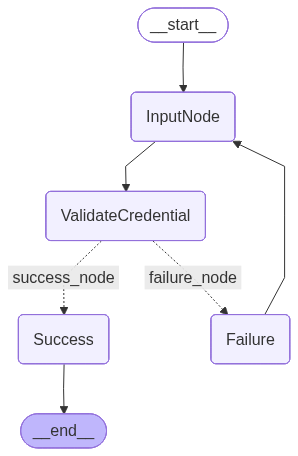

In [26]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

### Running the Application  

<p style='color: red'><b>Note:</b> The correct password is <code>Password123</code>, so make sure to enter that to authenticate successfully.</p>

In [27]:
inputs = {"username": "Om"}
result = app.invoke(inputs)
print(result)

{'username': 'Om'}
Username : Om Password : 123
{'username': 'Om', 'password': '123', 'is_authenticated': False, 'output': 'Not Successfull, please try again!'}
Username : Om Password : Password123
{'username': 'Om', 'password': 'Password123', 'is_authenticated': True, 'output': 'Authentication successful! Welcome.'}


In [28]:
result['output']

'Authentication successful! Welcome.'

## **Building a QA Workflow Specific to the Guided Project**

In [29]:
# Define the structure of the QA state
class QAState(TypedDict):
    # 'question' stores the user's input question. It can be a string or None if not provided.
    question: Optional[str]
    
    # 'context' stores relevant context about the guided project, if the question pertains to it.
    # If the question isn't related to the project, this will be None.
    context: Optional[str]
    
    # 'answer' stores the generated response or answer. It can be None until the answer is generated.
    answer: Optional[str]

In [30]:
# Create an example object
qa_state_example = QAState(
    question="What is the purpose of this guided project?",
    context="This project focuses on building a chatbot using Python.",
    answer=None
)

# Print the attributes
for key, value in qa_state_example.items():
    print(f"{key}: {value}")

question: What is the purpose of this guided project?
context: This project focuses on building a chatbot using Python.
answer: None


#### **Defining the Input Validation Node**

In [31]:
def input_validation_node(state):
    # Extract the question from the state, and strip any leading or trailing spaces
    question = state.get("question", "").strip()
    
    # If the question is empty, return an error message indicating invalid input
    if not question:
        return {"valid": False, "error": "Question cannot be empty."}
    
    # If the question is valid, return valid status
    return {"valid": True}

In [32]:
input_validation_node(qa_state_example)

{'valid': True}

#### **Defining the Context Provider**

In [33]:
def context_provider_node(state):
    question = state.get("question", "").lower()
    # Check if the question is related to the guided project
    if "langgraph" in question or "guided project" in question:
        context = (
            "This guided project is about using LangGraph, a Python library to design state-based workflows. "
            "LangGraph simplifies building complex applications by connecting modular nodes with conditional edges."
        )
        return {"context": context}
    # If unrelated, set context to null
    return {"context": None}

#### **Integrating LLM for QA Workflow**

In [34]:
def llm_qa_node(state):
    # Extract the question and context from the state
    question = state.get("question", "")
    context = state.get("context", None)

    # Check for missing context and return a fallback response
    if not context:
        return {"answer": "I don't have enough context to answer your question."}

    # Construct the prompt dynamically
    prompt = f"Context: {context}\nQuestion: {question}\nAnswer the question based on the provided context."

    # Use LangChain's ChatOpenAI to get the response
    try:
        response = perplexity_llm.invoke(prompt)
        return {"answer": response.content.strip()}
    except Exception as e:
        return {"answer": f"An error occurred: {str(e)}"}

#### **Creating the QA Workflow Graph**  

In [35]:
qa_workflow = StateGraph(QAState)

qa_workflow.add_node("InputNode", input_validation_node)
qa_workflow.add_node("ContextNode", context_provider_node)
qa_workflow.add_node("QANode", llm_qa_node)
qa_workflow.set_entry_point("InputNode")

qa_workflow.add_edge("InputNode", "ContextNode")
qa_workflow.add_edge("ContextNode", "QANode")
qa_workflow.add_edge("QANode", END)

qa_app = qa_workflow.compile()

### Plot the graph

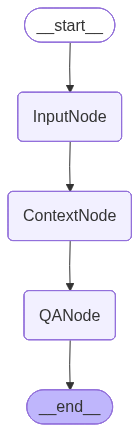

In [36]:
from IPython.display import Image

Image(qa_app.get_graph().draw_mermaid_png())

#### Ask an Irrelevant Question

In [37]:
qa_app.invoke({"question": "What is the weather today?"})

{'question': 'What is the weather today?',
 'context': None,
 'answer': "I don't have enough context to answer your question."}

#### Ask an Relevant Question

In [38]:
qa_app.invoke({"question": "What is LangGraph?"})

{'question': 'What is LangGraph?',
 'context': 'This guided project is about using LangGraph, a Python library to design state-based workflows. LangGraph simplifies building complex applications by connecting modular nodes with conditional edges.',
 'answer': '**LangGraph is a Python library within the LangChain ecosystem that simplifies building stateful, multi-actor applications with large language models (LLMs) by modeling workflows as graphs with nodes, edges, and state management.**[1][2][3][4][5][7]\n\nIt enables the creation of complex, cyclical graphs for coordinating multiple LLM agents or chains, handling state persistence across interactions, and supporting conditional logic, loops, and multi-step workflows.[1][2][3][4] Key components include:\n\n- **Nodes**: Python functions performing tasks like LLM calls, API interactions, or data processing, which update the shared state.[1][2][3][4]\n- **Edges**: Connections defining execution flow between nodes, including conditional b

In [39]:
qa_app.invoke({"question": "What is the best guided project?"})

{'question': 'What is the best guided project?',
 'context': 'This guided project is about using LangGraph, a Python library to design state-based workflows. LangGraph simplifies building complex applications by connecting modular nodes with conditional edges.',
 'answer': "**The guided project on using LangGraph to design state-based workflows, as described in the provided context, is the best one.** \n\nThis project excels by offering a hands-on, practical introduction to LangGraph's core features—connecting modular **nodes** (actions like function calls) with **conditional edges** (for dynamic flow control)—which simplifies building complex, stateful AI applications.[1][3] It aligns directly with the context's focus on state graphs, `GraphState` (a `TypedDict` for passing data between nodes), and workflow construction via `StateGraph`, including examples like parsing notices, escalation checks, and cyclic edges for follow-up questions.[1]\n\nSupporting details from related sources r

## Exercise

### 1 - Define the State type

Here, you will define the state schema used by the graph. It should keep track of:
- `n`: a counter starting from 1.
- `letter`: a randomly generated lowercase letter at each step.

In [40]:
import random
import string
from typing import TypedDict

from langgraph.graph import StateGraph, END

class ChainState(TypedDict):
    n: int
    letter: str

### 2 - Create `add()` node Function

This node should represent the `increment` step such that:
- It adds 1 to the current value of n.
- It randomly selects a lowercase letter and updates the letter field.

In [41]:
def add(state: ChainState) -> ChainState:
    random_letter = random.choice(string.ascii_lowercase)
    return {
        **state,
        "n": state["n"] + 1,
        "letter": random_letter,
    }

### 3 - Create `print_out()` node Function

This node should print the current state such that:
- It logs the value of n and the current random letter.
- The state is returned.

In [42]:
def print_out(state: ChainState) -> ChainState:
    print("Current n:", state["n"], "Letter:", state["letter"])
    return state

### 4 - Stop Condition

Create a function that has a termination condition:
- If the counter reaches 13 or more, the workflow should end.
- Otherwise, it should loop back to add node.


In [43]:
def stop_condition(state: ChainState) -> bool:
    return state["n"] >= 13

### 5 - Graph Construction

In this exercise, you'll build the LangGraph flow:

- Create a `StateGraph` object using the `ChainState` that you made.
- Add nodes `add` and `print`.
- Add an edge between `add` and `print`
- Add a conditional edge between `print` and `END` based on `stop_condition`.
- Set `add` as entry point of the graph.


In [44]:
workflow = StateGraph(ChainState)

workflow.add_node("add", add)
workflow.add_node("print", print_out)

workflow.add_edge("add", "print")

workflow.add_conditional_edges("print", stop_condition, {
    True: END,
    False: "add",
})

workflow.set_entry_point("add")

### 6 - Compile and Run

Compile the graph and start execution with the given initial input:
- The counter should begin at 1.
- Keep letter empty (to be filled in by the add node).


In [45]:
app = workflow.compile()

result = app.invoke({"n": 1, "letter": ""})

Current n: 2 Letter: x
Current n: 3 Letter: x
Current n: 4 Letter: s
Current n: 5 Letter: j
Current n: 6 Letter: c
Current n: 7 Letter: z
Current n: 8 Letter: k
Current n: 9 Letter: s
Current n: 10 Letter: b
Current n: 11 Letter: f
Current n: 12 Letter: p
Current n: 13 Letter: t


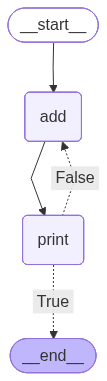

In [46]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())